# Device Agnostic Mobile Automation with OpenCV

This paper will examine the task of template matching on smartphone screenshots. It is useful to be able to locate a button on the screen for mobile automation and testing purposes, but classical template matching requires the template to be taken from the same device we are searching. We will be developing a technique that allows a single template to be used against devices of any screen size and pixel density. We will be attempting to locate the Snapchat add friend button on the screen of various devices.

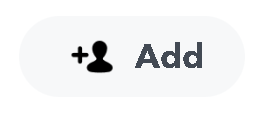

## Classical Template Matching

First, let us explore the classical template matching capabilities of OpenCV. This demo was adapted from the [OpenCV Documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html).

(147, 286)
(147, 431)
(147, 576)
(147, 721)
(147, 887)
(147, 888)
(147, 1054)
(147, 1055)
(147, 1199)
(147, 1200)
(147, 1344)
(147, 1345)


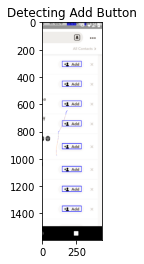

In [17]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img_rgb = cv.imread('SnapDataset/pixel2/IMG_0574.PNG')
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
template = cv.imread('SnapDataset/pixel2/ab.png',0)
w, h = template.shape[::-1]
res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
threshold = 0.95
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    print (pt)
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

plt.imshow(img_rgb)
plt.title('Detecting Add Button')
plt.show()

As you can see, we have successfully detected the Add button on the pixel 2 screenshot (although there are a few duplicates). The challenge will be if we can detect the Add button on the other screenshots while still using the pixel 2 template.

The demo below allows you to fiddle with the threshold amount. You can see that if you lower the threshold enough you can still find matches.

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact_manual(threshold=(0.4,1.0, 0.01))
def run(threshold):
    for imgPath in ['SnapDataset/Nexus7/Screenshot_20210419-153719.png', 'SnapDataset/iphoneXR/IMG_0578.PNG']:
        print ("Running for", imgPath)
        img_rgb = cv.imread(imgPath)
        img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
        template = cv.imread('SnapDataset/pixel2/ab.png',0)
        w, h = template.shape[::-1]
        res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
        loc = np.where( res >= threshold)

        count = 0
        for pt in zip(*loc[::-1]):
            count += 1
            cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

        print (count, "matches found")


        plt.imshow(img_rgb)
        plt.title('Detecting Add Button')
        plt.show()

interactive(children=(FloatSlider(value=0.69, description='threshold', max=1.0, min=0.4, step=0.01), Button(de…

With enough fiddling, you can find a "tipping point" we will call the **critical threshold** that allow the template to be detected for each device

**Nexus 7** (0.64 I have 24 matches, 0.65 I have zero)

**iPhone XR** (0.60 I have 21 matches, 0.61 I have zero)

Note that the critical threshold is device specific.

## Finding the critical threshold
Now, we will adapt the code to find the critical threshold automatically!

Running for SnapDataset/Nexus7/Screenshot_20210419-153719.png
Critical Threshold found at 0.6428843
1 matches found


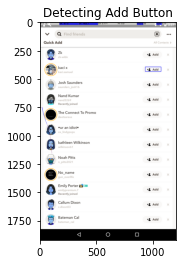

Running for SnapDataset/iphoneXR/IMG_0578.PNG
Critical Threshold found at 0.60761774
6 matches found


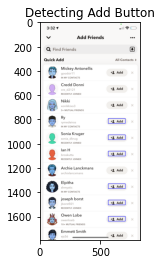

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


for imgPath in ['SnapDataset/Nexus7/Screenshot_20210419-153719.png', 'SnapDataset/iphoneXR/IMG_0578.PNG']:
    print ("Running for", imgPath)
    img_rgb = cv.imread(imgPath)
    img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
    template = cv.imread('SnapDataset/pixel2/ab.png',0)
    w, h = template.shape[::-1]
    res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
    
    # Set threshold to be the most strict it can be while still producing matches
    threshold = res.max()
    
    print ("Critical Threshold found at", threshold)
    
    loc = np.where( res >= threshold)

    count = 0
    for pt in zip(*loc[::-1]):
        count += 1
        cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

    print (count, "matches found")


    plt.imshow(img_rgb)
    plt.title('Detecting Add Button')
    plt.show()

## What happened here?
We are no longer detecting all of the buttons. This is because the critical threshold is the tipping point where the first match is able to be found. Due to slight variations in the rasterization of the graphics, all the add buttons are not uniform and will not match as well as the best matching button. We must reduce the critical threshold by some epsilon, and we will round down to 2 decimal points as a way to achieve this.

Running for SnapDataset/Nexus7/Screenshot_20210419-153719.png
Critical Threshold found at 0.64
24 matches found


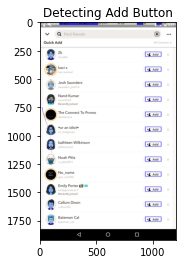

Running for SnapDataset/iphoneXR/IMG_0578.PNG
Critical Threshold found at 0.6
21 matches found


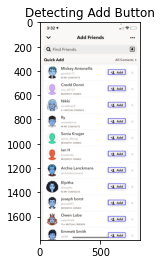

In [3]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math

for imgPath in ['SnapDataset/Nexus7/Screenshot_20210419-153719.png', 'SnapDataset/iphoneXR/IMG_0578.PNG']:
    print ("Running for", imgPath)
    img_rgb = cv.imread(imgPath)
    img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
    template = cv.imread('SnapDataset/pixel2/ab.png',0)
    w, h = template.shape[::-1]
    res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
    
    threshold = math.floor(res.max()*100)/100.0
    
    print ("Critical Threshold found at", threshold)
    
    loc = np.where( res >= threshold)

    count = 0
    for pt in zip(*loc[::-1]):
        count += 1
        cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

    print (count, "matches found")


    plt.imshow(img_rgb)
    plt.title('Detecting Add Button')
    plt.show()

## Making this useful

Now that we have a method of detecting the buttons on the screen, we need to do some modification to make it actually useful.

1. In images with no add buttons, we do not want false positives. This method as-is will lower the threshold until it finds a match no matter what.
2. Due to relaxing the threshold enough to actually detect things, each button is getting detected multiple times. We would like to detect only the number of buttons on the screen with no duplications.

## Tackling #1

Running for SnapDataset/Nexus7/Screenshot_20210419-153719.png
Critical Threshold found at 0.64
24 matches found


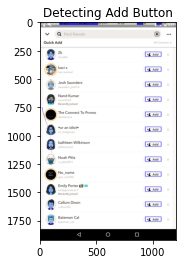

Running for SnapDataset/iphoneXR/IMG_0578.PNG
Critical Threshold found at 0.6
21 matches found


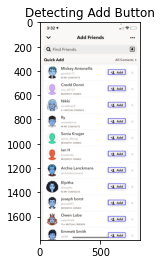

Running for SnapDataset/random_screenshot.png
Critical Threshold found at 0.55
0 matches found


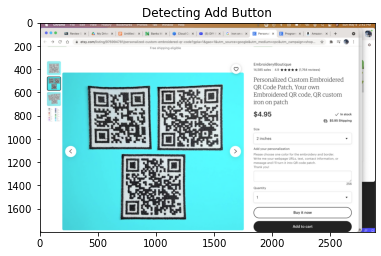

In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math

def detect(templatePath, imagePath, minThresh):
        print ("Running for", imagePath)
        img_rgb = cv.imread(imagePath)
        img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
        template = cv.imread(templatePath,0)
        w, h = template.shape[::-1]
        res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)

        # Enforcing lower bound of the threshold
        threshold = max(math.floor(res.max()*100)/100.0, minThresh)

        print ("Critical Threshold found at", threshold)

        loc = np.where( res >= threshold)

        count = 0
        for pt in zip(*loc[::-1]):
            count += 1
            cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

        print (count, "matches found")


        plt.imshow(img_rgb)
        plt.title('Detecting Add Button')
        plt.show()
        
for imgPath in ['SnapDataset/Nexus7/Screenshot_20210419-153719.png', 'SnapDataset/iphoneXR/IMG_0578.PNG', 'SnapDataset/random_screenshot.png']:
    detect('SnapDataset/pixel2/ab.png', imgPath, 0.55)
    

By enforcing a minimum threshold, we can stop the algorithm from finding false positives.

## Solving #2

Running for SnapDataset/Nexus7/Screenshot_20210419-153719.png
Critical Threshold found at 0.64
ALL POINTS [(928, 263), (929, 263), (928, 395), (929, 395), (928, 527), (929, 527), (928, 659), (929, 659), (928, 791), (929, 791), (928, 923), (929, 923), (928, 1055), (929, 1055), (928, 1187), (929, 1187), (928, 1319), (929, 1319), (928, 1451), (929, 1451), (928, 1583), (929, 1583), (928, 1715), (929, 1715)]
UNIQUE POINTS [(928, 263), (928, 395), (928, 527), (928, 659), (928, 791), (928, 923), (928, 1055), (928, 1187), (928, 1319), (928, 1451), (928, 1583), (928, 1715)]
12


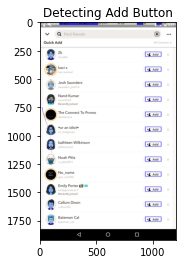

Running for SnapDataset/iphoneXR/IMG_0578.PNG
Critical Threshold found at 0.6
ALL POINTS [(558, 391), (559, 391), (558, 525), (559, 525), (558, 659), (559, 659), (558, 793), (559, 793), (558, 927), (559, 927), (558, 1061), (559, 1061), (558, 1195), (559, 1195), (558, 1329), (559, 1329), (558, 1463), (559, 1463), (558, 1597), (559, 1597), (559, 1731)]
UNIQUE POINTS [(558, 391), (558, 525), (558, 659), (558, 793), (558, 927), (558, 1061), (558, 1195), (558, 1329), (558, 1463), (558, 1597), (559, 1731)]
11


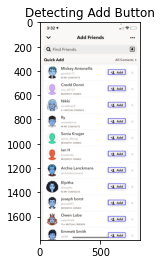

Running for SnapDataset/random_screenshot.png
Critical Threshold found at 0.55
ALL POINTS []
UNIQUE POINTS []
0


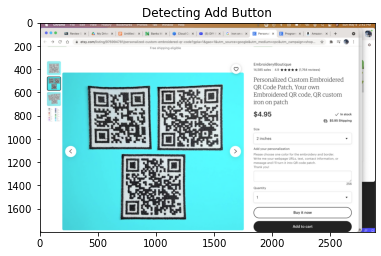

In [5]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math

def detect(templatePath, imagePath, minThresh, collapseRng):
        print ("Running for", imagePath)
        img_rgb = cv.imread(imagePath)
        img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
        template = cv.imread(templatePath,0)
        w, h = template.shape[::-1]
        res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)

        threshold = max(math.floor(res.max()*100)/100.0, minThresh)

        print ("Critical Threshold found at", threshold)

        loc = np.where( res >= threshold)

        points = []
        
        for pt in zip(*loc[::-1]):
            cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
            points.append(pt)

        print ("ALL POINTS", points)
        
        unique_points = []
        
        # collapse points that are within collapseRng from each other
        for point in points:
            unique = True
            for upoint in unique_points:
                if ((point[0]-upoint[0])**2 + (point[1]-upoint[1])**2)**0.5 < collapseRng:
                    unique = False
            
            if unique:
                unique_points.append(point)
            

        print("UNIQUE POINTS", unique_points)
        print(len(unique_points))

        plt.imshow(img_rgb)
        plt.title('Detecting Add Button')
        plt.show()
        
for imgPath in ['SnapDataset/Nexus7/Screenshot_20210419-153719.png', 'SnapDataset/iphoneXR/IMG_0578.PNG', 'SnapDataset/random_screenshot.png']:
    detect('SnapDataset/pixel2/ab.png', imgPath, 0.55, 5)

# Putting it all together

Now that we have worked out the issues in the code, lets make the function useful by having it output all the matches in JSON format

In [6]:
import cv2 as cv
import numpy as np
import math
import json

def detect(templatePath, imagePath, minThresh, collapseRng):
        img_rgb = cv.imread(imagePath)
        img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
        template = cv.imread(templatePath,0)
        w, h = template.shape[::-1]
        res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)

        threshold = max(math.floor(res.max()*100)/100.0, minThresh)

        loc = np.where( res >= threshold)

        points = []
        
        for pt in zip(*loc[::-1]):
            cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
            points.append(pt)
        
        unique_points = []
        
        # collapse points that are within collapseRng from each other
        for point in points:
            unique = True
            for upoint in unique_points:
                if ((point[0]-upoint[0])**2 + (point[1]-upoint[1])**2)**0.5 < collapseRng:
                    unique = False
            
            if unique:
                # Add to list and convert int64 tuple to int array
                unique_points.append([int(point[0]), int(point[1])])
            
        print(json.dumps(unique_points))

        
for imgPath in ['SnapDataset/Nexus7/Screenshot_20210419-153719.png', 'SnapDataset/iphoneXR/IMG_0578.PNG', 'SnapDataset/random_screenshot.png']:
    print("\n\n\n OUTPUT FOR", imgPath, "\n\n\n")
    detect('SnapDataset/pixel2/ab.png', imgPath, 0.55, 5)




 OUTPUT FOR SnapDataset/Nexus7/Screenshot_20210419-153719.png 



[[928, 263], [928, 395], [928, 527], [928, 659], [928, 791], [928, 923], [928, 1055], [928, 1187], [928, 1319], [928, 1451], [928, 1583], [928, 1715]]



 OUTPUT FOR SnapDataset/iphoneXR/IMG_0578.PNG 



[[558, 391], [558, 525], [558, 659], [558, 793], [558, 927], [558, 1061], [558, 1195], [558, 1329], [558, 1463], [558, 1597], [559, 1731]]



 OUTPUT FOR SnapDataset/random_screenshot.png 



[]


# Conclusion

We have been able to successfully identify the coordinates of all add buttons on the screen by finding a critical threshold that does not trigger false negatives or positives. The same algorithm with the same template can be applied across all devices, operating systems, and screen sizes! 

|Issue|Solution|
|-----|--------|
|Critical threshold too strict|reduce the critical threshold by some epsilon (we used rounding down as a stand in)|
|Matches always found even when there are none|Set a lower bound on possible critical threshold|
|Matches show up in bunches|Collapse matches that are within the `collapseRng`|

The programmer must decide on the minimum threshold and collapseRng values, but those values once found have been working across all device types, so this is a truely device agnostic template matching algorithm! This algorithm was designed to be used in tandem with a program that can

1. Pull screenshots from a cellphone
2. Feed screenshot into this algorithm and get back coordinates of add buttons
3. Send touch events to the coordinates of the add buttons.

All of the phone screenshotting and interacting can be done trivially over [ADB](https://developer.android.com/studio/command-line/adb) and this technique can be used to automate mobile processes across devices.